In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 

import utils.sde_lib
import utils.models
import utils.losses as losses
from utils.datasets import get_dataset
import utils.samplers
from utils.misc import dotdict, batch_matrix_product
from utils.diff import batch_div_exact, hutch_div


In [2]:
# ckpts = torch.load('checkpoints/guans/stage_8.npz')
# state_dict_backward = ckpts['z_b']
# state_dict_forward = ckpts['z_f']
# state_dict_backward = {k.replace('net.', ''): v for k, v in state_dict_backward.items()}
# state_dict_forward = {k.replace('net.', ''): v for k, v in state_dict_forward.items()}

# model_backward = ToyPolicy().to(device=device)
# model_backward.load_state_dict(state_dict_backward)
# model_backward.requires_grad_(False)
# model_forward = ToyPolicy().to(device=device)
# model_forward.load_state_dict(state_dict_forward)
# model_forward.requires_grad_(False)

# def forward_score(x,t):
#     return model_forward(x,t)/5**.5
# def backward_score(x,t):
#     return model_backward(x,t)/5**.5

    
# sb = utils.sde_lib.SchrodingerBridge(backward_score=model_backward, forward_score=model_forward)

In [3]:
opts =  dotdict({
    'dataset': 'spiral',
    'lr' : 3e-4,
    'num_iters' : 1000,
    'batch_size' : 512, 
    
})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = get_dataset(opts)
dim = dataset.dim

In [4]:
data = dataset.sample(512).to(device=device)
aug_data = torch.cat((data, torch.zeros_like(data)),dim=-1)
time_pts = torch.linspace(0,1,100, device=device)
backward = True


itr=5000
model_path = f'./checkpoints/spiral-momentum-sb/itr_{itr}'

model_backward = torch.load(os.path.join(model_path,'backward_ema.pt'))
model_forward = torch.load(os.path.join(model_path,'forward_ema.pt'))

with torch.no_grad():
    sb = utils.sde_lib.LinearMomentumSchrodingerBridge(backward_model=model_backward, forward_model=model_forward)

    in_cond = sb.prior_sampling(shape=aug_data.shape,device=data.device) if backward else aug_data
    xt, trajectory, frozen_policy = sb.get_trajectories_for_loss(in_cond, time_pts,forward=not backward)

# xt , trajectory = sb.sample(aug_data.shape, device)

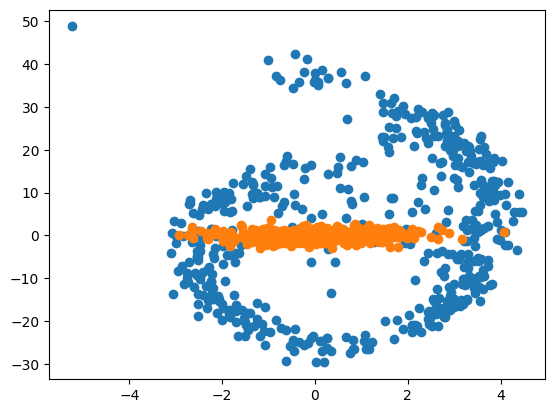

In [5]:
# print(losses.standard_sb_loss(sb,data))
plt.scatter(xt[:,0].detach().cpu(),xt[:,1].detach().cpu())
plt.scatter(in_cond[:,0].detach().cpu(),in_cond[:,1].detach().cpu())
plt.show()

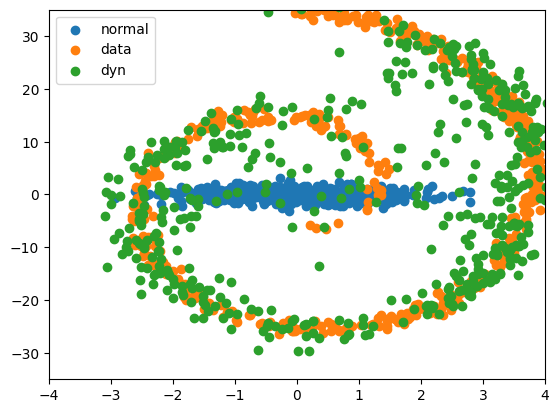

In [6]:
# data = dataset.sample(1000).to(device=device)
# aug_data = torch.cat((data, torch.zeros_like(data)),dim=-1)

# noise, trajectory = cld.sample((1000,4),device,False, in_cond=aug_data)
rand = torch.randn_like(xt)
for i in range(trajectory.shape[1]):
    plt.close()
    plt.xlim(-4,4)
    plt.ylim(-35,35)
    plt.scatter(rand[:,0].cpu(),rand[:,1].cpu(),label='normal')
    plt.scatter(aug_data[:,0].cpu(),aug_data[:,1].cpu(),label='data')
    plt.scatter(trajectory[:,i,0].cpu(),trajectory[:,i,1].cpu(),label='dyn')
    plt.legend()
    plt.savefig(f'trajectory/{i}.png')